In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Carregando o vocabulário

In [2]:
import json

with open('./data/vocab.json', 'r') as infile:
    vocab = json.load(infile)

vocabSize = len(vocab['idx'])

print('Vocabulary size:', vocabSize)

Vocabulary size: 15244


### Configurações e Hiperparâmetros

In [3]:
import torch
import torch.nn as nn
from data import get_loaders
from train import train, test, check_input
import models 
from matplotlib import pyplot as plt

In [4]:
classes = [
  'negative',
  'somewhat negative',
  'neutral',
  'somewhat positive',
  'positive'
]

In [5]:
def plot_instance(instance_id):
    text = train_loader.dataset.texts[instance_id]
    label = train_loader.dataset.labels[instance_id]
    label_str = classes[train_loader.dataset.labels[instance_id]]
    print('\nExample:')
    print(text)
    print('Label:', label, '-', label_str)

In [6]:
data_path = './data/'
device_name = 'cuda'
batch_size = 1024
nb_epochs = 12
log_interval = 5
lr = 1e-2
lr_step = 4
num_layers = 3
dropout = .02

In [7]:
device = torch.device(device_name)

train_loader, valid_loader = get_loaders(
    data_path=data_path, 
    batch_size=batch_size, 
    splits=['train', 'valid'],
)

nb_words = len(train_loader.dataset.vocab)

print(
    'Train size: ', 
    len(train_loader.dataset.texts),
    len(train_loader.dataset.labels)
)
print(
    'Valid size : ', 
    len(valid_loader.dataset.texts),
    len(valid_loader.dataset.labels)
)

plot_instance(0)
plot_instance(1015)
plot_instance(5136)
plot_instance(8974)


Train size:  99878 99878
Valid size :  24970 24970

Example:
a zombie
Label: 2 - neutral

Example:
the assumption
Label: 2 - neutral

Example:
hilarious and
Label: 4 - positive

Example:
good cast
Label: 3 - somewhat positive


In [8]:
def average_pooling(instances, lens):
    return torch.stack([
        text[:l].mean(0) for text, l in zip(instances, lens)
    ])


class TextLSTM(nn.Module):
    def __init__(self, num_embeddings=vocabSize, embedding_dim=100):
        '''
            num_embeddings: number of words in the dictionary
            embedding_dim: size of the word-embedding vector
        '''
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim,
        )
        self.rnn = nn.LSTM(
            input_size=100, hidden_size=32, 
            batch_first=True, bidirectional=True,
            num_layers=num_layers, dropout = dropout
        )
        self.fc1 = nn.Linear(32*2, 32*2)
        self.fc2 = nn.Linear(32*2, len(classes))
        
    def forward(self, x, lengths):
        # Transforma índices das palavras em vetores 
        x = self.embedding(x)
        # Processa vetores das palavras com uma rede recorrente
        hidden, output = self.rnn(x)
        # Faz a média das ativações de todas as iterações recorrentes
        vector = average_pooling(hidden, lengths)
        # Camada linear para classificacao
        x = self.fc1(vector)
        x = self.fc2(x)
        return x


In [9]:
model = TextLSTM()
model = model.to(device)

dummy_pred = check_input(model, device)

Passed


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step)

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luciano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Treino


* * * Training * * *
Train Epoch:   1 [     0/ 99878 (0%)]	Loss: 1.675949
Train Epoch:   1 [  5120/ 99878 (5%)]	Loss: 1.286020
Train Epoch:   1 [ 10240/ 99878 (10%)]	Loss: 1.257897
Train Epoch:   1 [ 15360/ 99878 (15%)]	Loss: 1.214837
Train Epoch:   1 [ 20480/ 99878 (20%)]	Loss: 1.206442
Train Epoch:   1 [ 25600/ 99878 (26%)]	Loss: 1.173116
Train Epoch:   1 [ 30720/ 99878 (31%)]	Loss: 1.215088
Train Epoch:   1 [ 35840/ 99878 (36%)]	Loss: 1.154860
Train Epoch:   1 [ 40960/ 99878 (41%)]	Loss: 1.161924
Train Epoch:   1 [ 46080/ 99878 (46%)]	Loss: 1.123503
Train Epoch:   1 [ 51200/ 99878 (51%)]	Loss: 1.116763
Train Epoch:   1 [ 56320/ 99878 (56%)]	Loss: 1.135337
Train Epoch:   1 [ 61440/ 99878 (61%)]	Loss: 1.129986
Train Epoch:   1 [ 66560/ 99878 (66%)]	Loss: 1.073572
Train Epoch:   1 [ 71680/ 99878 (71%)]	Loss: 1.112024
Train Epoch:   1 [ 76800/ 99878 (77%)]	Loss: 1.087072
Train Epoch:   1 [ 81920/ 99878 (82%)]	Loss: 1.004596
Train Epoch:   1 [ 87040/ 99878 (87%)]	Loss: 1.051567
Train Ep

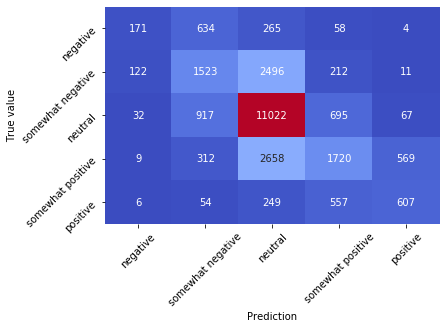


* * * Training * * *
Train Epoch:   2 [     0/ 99878 (0%)]	Loss: 0.871819
Train Epoch:   2 [  5120/ 99878 (5%)]	Loss: 0.913772
Train Epoch:   2 [ 10240/ 99878 (10%)]	Loss: 0.936868
Train Epoch:   2 [ 15360/ 99878 (15%)]	Loss: 0.917157
Train Epoch:   2 [ 20480/ 99878 (20%)]	Loss: 0.871465
Train Epoch:   2 [ 25600/ 99878 (26%)]	Loss: 0.882302
Train Epoch:   2 [ 30720/ 99878 (31%)]	Loss: 0.892504
Train Epoch:   2 [ 35840/ 99878 (36%)]	Loss: 0.862885
Train Epoch:   2 [ 40960/ 99878 (41%)]	Loss: 0.829906
Train Epoch:   2 [ 46080/ 99878 (46%)]	Loss: 0.876092
Train Epoch:   2 [ 51200/ 99878 (51%)]	Loss: 0.883094
Train Epoch:   2 [ 56320/ 99878 (56%)]	Loss: 0.884546
Train Epoch:   2 [ 61440/ 99878 (61%)]	Loss: 0.889416
Train Epoch:   2 [ 66560/ 99878 (66%)]	Loss: 0.827800
Train Epoch:   2 [ 71680/ 99878 (71%)]	Loss: 0.864974
Train Epoch:   2 [ 76800/ 99878 (77%)]	Loss: 0.839593
Train Epoch:   2 [ 81920/ 99878 (82%)]	Loss: 0.837359
Train Epoch:   2 [ 87040/ 99878 (87%)]	Loss: 0.859010
Train Ep

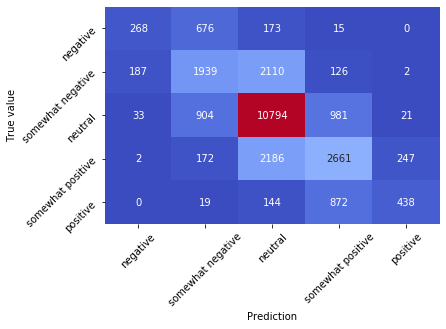


* * * Training * * *
Train Epoch:   3 [     0/ 99878 (0%)]	Loss: 0.759920
Train Epoch:   3 [  5120/ 99878 (5%)]	Loss: 0.740561
Train Epoch:   3 [ 10240/ 99878 (10%)]	Loss: 0.765427
Train Epoch:   3 [ 15360/ 99878 (15%)]	Loss: 0.748553
Train Epoch:   3 [ 20480/ 99878 (20%)]	Loss: 0.782549
Train Epoch:   3 [ 25600/ 99878 (26%)]	Loss: 0.772216
Train Epoch:   3 [ 30720/ 99878 (31%)]	Loss: 0.758804
Train Epoch:   3 [ 35840/ 99878 (36%)]	Loss: 0.761932
Train Epoch:   3 [ 40960/ 99878 (41%)]	Loss: 0.711304
Train Epoch:   3 [ 46080/ 99878 (46%)]	Loss: 0.744126
Train Epoch:   3 [ 51200/ 99878 (51%)]	Loss: 0.767264
Train Epoch:   3 [ 56320/ 99878 (56%)]	Loss: 0.747938
Train Epoch:   3 [ 61440/ 99878 (61%)]	Loss: 0.764436
Train Epoch:   3 [ 66560/ 99878 (66%)]	Loss: 0.736352
Train Epoch:   3 [ 71680/ 99878 (71%)]	Loss: 0.729203
Train Epoch:   3 [ 76800/ 99878 (77%)]	Loss: 0.728607
Train Epoch:   3 [ 81920/ 99878 (82%)]	Loss: 0.775778
Train Epoch:   3 [ 87040/ 99878 (87%)]	Loss: 0.783303
Train Ep

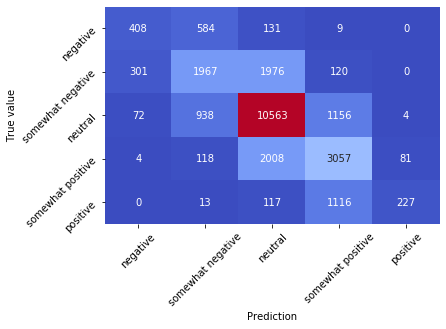


* * * Training * * *
Train Epoch:   4 [     0/ 99878 (0%)]	Loss: 0.679218
Train Epoch:   4 [  5120/ 99878 (5%)]	Loss: 0.674113
Train Epoch:   4 [ 10240/ 99878 (10%)]	Loss: 0.627748
Train Epoch:   4 [ 15360/ 99878 (15%)]	Loss: 0.669426
Train Epoch:   4 [ 20480/ 99878 (20%)]	Loss: 0.654853
Train Epoch:   4 [ 25600/ 99878 (26%)]	Loss: 0.611486
Train Epoch:   4 [ 30720/ 99878 (31%)]	Loss: 0.640906
Train Epoch:   4 [ 35840/ 99878 (36%)]	Loss: 0.619553
Train Epoch:   4 [ 40960/ 99878 (41%)]	Loss: 0.662067
Train Epoch:   4 [ 46080/ 99878 (46%)]	Loss: 0.664597
Train Epoch:   4 [ 51200/ 99878 (51%)]	Loss: 0.695236
Train Epoch:   4 [ 56320/ 99878 (56%)]	Loss: 0.682786
Train Epoch:   4 [ 61440/ 99878 (61%)]	Loss: 0.709652
Train Epoch:   4 [ 66560/ 99878 (66%)]	Loss: 0.665488
Train Epoch:   4 [ 71680/ 99878 (71%)]	Loss: 0.679862
Train Epoch:   4 [ 76800/ 99878 (77%)]	Loss: 0.669723
Train Epoch:   4 [ 81920/ 99878 (82%)]	Loss: 0.685585
Train Epoch:   4 [ 87040/ 99878 (87%)]	Loss: 0.675841
Train Ep

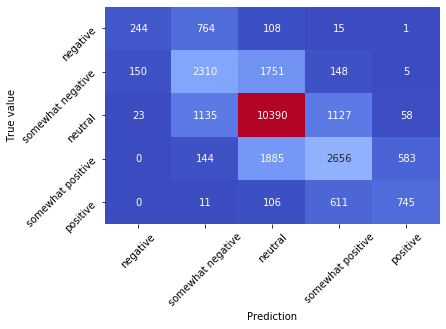


* * * Training * * *
Train Epoch:   5 [     0/ 99878 (0%)]	Loss: 0.621853
Train Epoch:   5 [  5120/ 99878 (5%)]	Loss: 0.587939
Train Epoch:   5 [ 10240/ 99878 (10%)]	Loss: 0.566723
Train Epoch:   5 [ 15360/ 99878 (15%)]	Loss: 0.549415
Train Epoch:   5 [ 20480/ 99878 (20%)]	Loss: 0.606000
Train Epoch:   5 [ 25600/ 99878 (26%)]	Loss: 0.532603
Train Epoch:   5 [ 30720/ 99878 (31%)]	Loss: 0.582821
Train Epoch:   5 [ 35840/ 99878 (36%)]	Loss: 0.528166
Train Epoch:   5 [ 40960/ 99878 (41%)]	Loss: 0.557058
Train Epoch:   5 [ 46080/ 99878 (46%)]	Loss: 0.584331
Train Epoch:   5 [ 51200/ 99878 (51%)]	Loss: 0.601921
Train Epoch:   5 [ 56320/ 99878 (56%)]	Loss: 0.561255
Train Epoch:   5 [ 61440/ 99878 (61%)]	Loss: 0.586178
Train Epoch:   5 [ 66560/ 99878 (66%)]	Loss: 0.538256
Train Epoch:   5 [ 71680/ 99878 (71%)]	Loss: 0.556678
Train Epoch:   5 [ 76800/ 99878 (77%)]	Loss: 0.545228
Train Epoch:   5 [ 81920/ 99878 (82%)]	Loss: 0.535530
Train Epoch:   5 [ 87040/ 99878 (87%)]	Loss: 0.567389
Train Ep

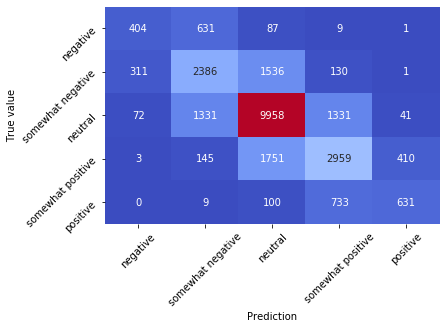


* * * Training * * *
Train Epoch:   6 [     0/ 99878 (0%)]	Loss: 0.520058
Train Epoch:   6 [  5120/ 99878 (5%)]	Loss: 0.529375
Train Epoch:   6 [ 10240/ 99878 (10%)]	Loss: 0.538116
Train Epoch:   6 [ 15360/ 99878 (15%)]	Loss: 0.519292
Train Epoch:   6 [ 20480/ 99878 (20%)]	Loss: 0.513032
Train Epoch:   6 [ 25600/ 99878 (26%)]	Loss: 0.535551
Train Epoch:   6 [ 30720/ 99878 (31%)]	Loss: 0.508256
Train Epoch:   6 [ 35840/ 99878 (36%)]	Loss: 0.523623
Train Epoch:   6 [ 40960/ 99878 (41%)]	Loss: 0.508191
Train Epoch:   6 [ 46080/ 99878 (46%)]	Loss: 0.536340
Train Epoch:   6 [ 51200/ 99878 (51%)]	Loss: 0.578621
Train Epoch:   6 [ 56320/ 99878 (56%)]	Loss: 0.497948
Train Epoch:   6 [ 61440/ 99878 (61%)]	Loss: 0.526955
Train Epoch:   6 [ 66560/ 99878 (66%)]	Loss: 0.532123
Train Epoch:   6 [ 71680/ 99878 (71%)]	Loss: 0.529966
Train Epoch:   6 [ 76800/ 99878 (77%)]	Loss: 0.536792
Train Epoch:   6 [ 81920/ 99878 (82%)]	Loss: 0.502791
Train Epoch:   6 [ 87040/ 99878 (87%)]	Loss: 0.563981
Train Ep

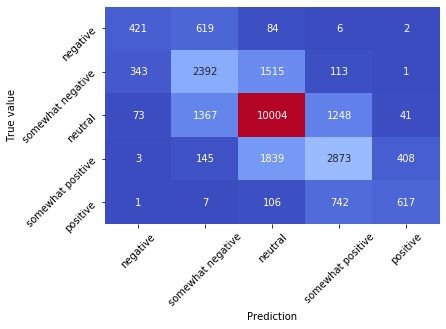


* * * Training * * *
Train Epoch:   7 [     0/ 99878 (0%)]	Loss: 0.500383
Train Epoch:   7 [  5120/ 99878 (5%)]	Loss: 0.560604
Train Epoch:   7 [ 10240/ 99878 (10%)]	Loss: 0.495050
Train Epoch:   7 [ 15360/ 99878 (15%)]	Loss: 0.524679
Train Epoch:   7 [ 20480/ 99878 (20%)]	Loss: 0.517208
Train Epoch:   7 [ 25600/ 99878 (26%)]	Loss: 0.497654
Train Epoch:   7 [ 30720/ 99878 (31%)]	Loss: 0.469330
Train Epoch:   7 [ 35840/ 99878 (36%)]	Loss: 0.510099
Train Epoch:   7 [ 40960/ 99878 (41%)]	Loss: 0.483611
Train Epoch:   7 [ 46080/ 99878 (46%)]	Loss: 0.513652
Train Epoch:   7 [ 51200/ 99878 (51%)]	Loss: 0.507439
Train Epoch:   7 [ 56320/ 99878 (56%)]	Loss: 0.464316
Train Epoch:   7 [ 61440/ 99878 (61%)]	Loss: 0.511019
Train Epoch:   7 [ 66560/ 99878 (66%)]	Loss: 0.522587
Train Epoch:   7 [ 71680/ 99878 (71%)]	Loss: 0.521854
Train Epoch:   7 [ 76800/ 99878 (77%)]	Loss: 0.503264
Train Epoch:   7 [ 81920/ 99878 (82%)]	Loss: 0.525607
Train Epoch:   7 [ 87040/ 99878 (87%)]	Loss: 0.541204
Train Ep

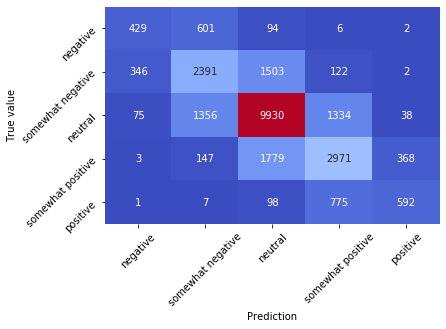


* * * Training * * *
Train Epoch:   8 [     0/ 99878 (0%)]	Loss: 0.496103
Train Epoch:   8 [  5120/ 99878 (5%)]	Loss: 0.475261
Train Epoch:   8 [ 10240/ 99878 (10%)]	Loss: 0.453972
Train Epoch:   8 [ 15360/ 99878 (15%)]	Loss: 0.451493
Train Epoch:   8 [ 20480/ 99878 (20%)]	Loss: 0.464979
Train Epoch:   8 [ 25600/ 99878 (26%)]	Loss: 0.485494
Train Epoch:   8 [ 30720/ 99878 (31%)]	Loss: 0.475353
Train Epoch:   8 [ 35840/ 99878 (36%)]	Loss: 0.490944
Train Epoch:   8 [ 40960/ 99878 (41%)]	Loss: 0.469610
Train Epoch:   8 [ 46080/ 99878 (46%)]	Loss: 0.466305
Train Epoch:   8 [ 51200/ 99878 (51%)]	Loss: 0.468554
Train Epoch:   8 [ 56320/ 99878 (56%)]	Loss: 0.489954
Train Epoch:   8 [ 61440/ 99878 (61%)]	Loss: 0.471442
Train Epoch:   8 [ 66560/ 99878 (66%)]	Loss: 0.472156
Train Epoch:   8 [ 71680/ 99878 (71%)]	Loss: 0.514444
Train Epoch:   8 [ 76800/ 99878 (77%)]	Loss: 0.500242
Train Epoch:   8 [ 81920/ 99878 (82%)]	Loss: 0.481086
Train Epoch:   8 [ 87040/ 99878 (87%)]	Loss: 0.508610
Train Ep

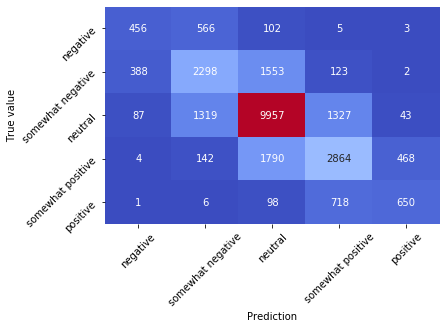


* * * Training * * *
Train Epoch:   9 [     0/ 99878 (0%)]	Loss: 0.471311
Train Epoch:   9 [  5120/ 99878 (5%)]	Loss: 0.455274
Train Epoch:   9 [ 10240/ 99878 (10%)]	Loss: 0.465525
Train Epoch:   9 [ 15360/ 99878 (15%)]	Loss: 0.425259
Train Epoch:   9 [ 20480/ 99878 (20%)]	Loss: 0.436945
Train Epoch:   9 [ 25600/ 99878 (26%)]	Loss: 0.493333
Train Epoch:   9 [ 30720/ 99878 (31%)]	Loss: 0.431587
Train Epoch:   9 [ 35840/ 99878 (36%)]	Loss: 0.458265
Train Epoch:   9 [ 40960/ 99878 (41%)]	Loss: 0.451932
Train Epoch:   9 [ 46080/ 99878 (46%)]	Loss: 0.481148
Train Epoch:   9 [ 51200/ 99878 (51%)]	Loss: 0.478567
Train Epoch:   9 [ 56320/ 99878 (56%)]	Loss: 0.441345
Train Epoch:   9 [ 61440/ 99878 (61%)]	Loss: 0.446773
Train Epoch:   9 [ 66560/ 99878 (66%)]	Loss: 0.452158
Train Epoch:   9 [ 71680/ 99878 (71%)]	Loss: 0.467731
Train Epoch:   9 [ 76800/ 99878 (77%)]	Loss: 0.439520
Train Epoch:   9 [ 81920/ 99878 (82%)]	Loss: 0.467040
Train Epoch:   9 [ 87040/ 99878 (87%)]	Loss: 0.492756
Train Ep

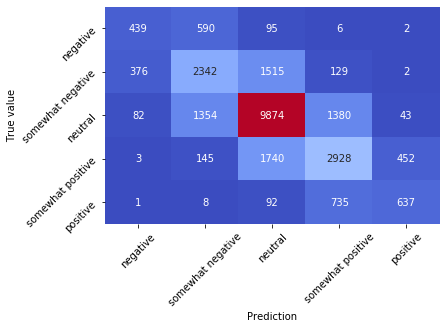


* * * Training * * *
Train Epoch:  10 [     0/ 99878 (0%)]	Loss: 0.413425
Train Epoch:  10 [  5120/ 99878 (5%)]	Loss: 0.491560
Train Epoch:  10 [ 10240/ 99878 (10%)]	Loss: 0.421754
Train Epoch:  10 [ 15360/ 99878 (15%)]	Loss: 0.422590
Train Epoch:  10 [ 20480/ 99878 (20%)]	Loss: 0.476965
Train Epoch:  10 [ 25600/ 99878 (26%)]	Loss: 0.485549
Train Epoch:  10 [ 30720/ 99878 (31%)]	Loss: 0.460532
Train Epoch:  10 [ 35840/ 99878 (36%)]	Loss: 0.436224
Train Epoch:  10 [ 40960/ 99878 (41%)]	Loss: 0.435242
Train Epoch:  10 [ 46080/ 99878 (46%)]	Loss: 0.495707
Train Epoch:  10 [ 51200/ 99878 (51%)]	Loss: 0.501104
Train Epoch:  10 [ 56320/ 99878 (56%)]	Loss: 0.458891
Train Epoch:  10 [ 61440/ 99878 (61%)]	Loss: 0.445764
Train Epoch:  10 [ 66560/ 99878 (66%)]	Loss: 0.470746
Train Epoch:  10 [ 71680/ 99878 (71%)]	Loss: 0.444463
Train Epoch:  10 [ 76800/ 99878 (77%)]	Loss: 0.464554
Train Epoch:  10 [ 81920/ 99878 (82%)]	Loss: 0.446109
Train Epoch:  10 [ 87040/ 99878 (87%)]	Loss: 0.416640
Train Ep

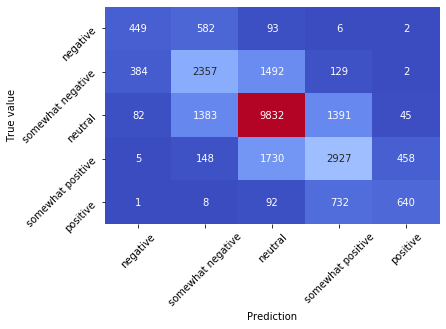


* * * Training * * *
Train Epoch:  11 [     0/ 99878 (0%)]	Loss: 0.430775
Train Epoch:  11 [  5120/ 99878 (5%)]	Loss: 0.466998
Train Epoch:  11 [ 10240/ 99878 (10%)]	Loss: 0.428775
Train Epoch:  11 [ 15360/ 99878 (15%)]	Loss: 0.495581
Train Epoch:  11 [ 20480/ 99878 (20%)]	Loss: 0.419279
Train Epoch:  11 [ 25600/ 99878 (26%)]	Loss: 0.434984
Train Epoch:  11 [ 30720/ 99878 (31%)]	Loss: 0.434277
Train Epoch:  11 [ 35840/ 99878 (36%)]	Loss: 0.474880
Train Epoch:  11 [ 40960/ 99878 (41%)]	Loss: 0.432892
Train Epoch:  11 [ 46080/ 99878 (46%)]	Loss: 0.441514
Train Epoch:  11 [ 51200/ 99878 (51%)]	Loss: 0.451517
Train Epoch:  11 [ 56320/ 99878 (56%)]	Loss: 0.436999
Train Epoch:  11 [ 61440/ 99878 (61%)]	Loss: 0.432566
Train Epoch:  11 [ 66560/ 99878 (66%)]	Loss: 0.458267
Train Epoch:  11 [ 71680/ 99878 (71%)]	Loss: 0.472876
Train Epoch:  11 [ 76800/ 99878 (77%)]	Loss: 0.486142
Train Epoch:  11 [ 81920/ 99878 (82%)]	Loss: 0.461100
Train Epoch:  11 [ 87040/ 99878 (87%)]	Loss: 0.471671
Train Ep

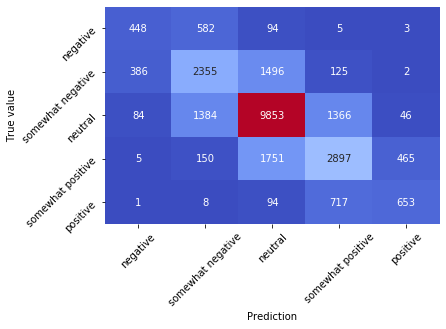


* * * Training * * *
Train Epoch:  12 [     0/ 99878 (0%)]	Loss: 0.457079
Train Epoch:  12 [  5120/ 99878 (5%)]	Loss: 0.468090
Train Epoch:  12 [ 10240/ 99878 (10%)]	Loss: 0.463369
Train Epoch:  12 [ 15360/ 99878 (15%)]	Loss: 0.441068
Train Epoch:  12 [ 20480/ 99878 (20%)]	Loss: 0.459715
Train Epoch:  12 [ 25600/ 99878 (26%)]	Loss: 0.450662
Train Epoch:  12 [ 30720/ 99878 (31%)]	Loss: 0.449645
Train Epoch:  12 [ 35840/ 99878 (36%)]	Loss: 0.474738
Train Epoch:  12 [ 40960/ 99878 (41%)]	Loss: 0.426276
Train Epoch:  12 [ 46080/ 99878 (46%)]	Loss: 0.461216
Train Epoch:  12 [ 51200/ 99878 (51%)]	Loss: 0.459087
Train Epoch:  12 [ 56320/ 99878 (56%)]	Loss: 0.454811
Train Epoch:  12 [ 61440/ 99878 (61%)]	Loss: 0.479619
Train Epoch:  12 [ 66560/ 99878 (66%)]	Loss: 0.408293
Train Epoch:  12 [ 71680/ 99878 (71%)]	Loss: 0.432500
Train Epoch:  12 [ 76800/ 99878 (77%)]	Loss: 0.440881
Train Epoch:  12 [ 81920/ 99878 (82%)]	Loss: 0.448454
Train Epoch:  12 [ 87040/ 99878 (87%)]	Loss: 0.413310
Train Ep

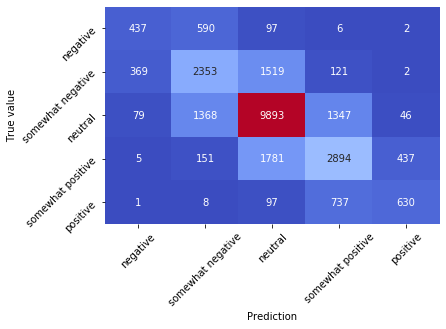

In [12]:
history = train(
    model=model, train_loader=train_loader, test_loader=valid_loader, classes=classes,
    device=device, optimizer=optimizer, lr_scheduler=lr_scheduler,
    nb_epochs=nb_epochs, log_interval=log_interval
)

### Resultados do treino

In [13]:
print('Max val acc: {:.2f}%'.format(max(history['val_acc'])))

Max val acc: 65.46%


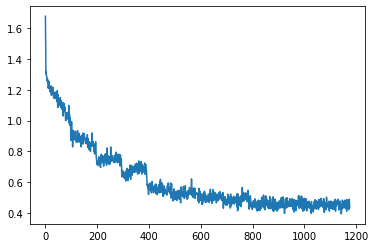

In [14]:
plt.plot(history['train_loss'])
plt.show()

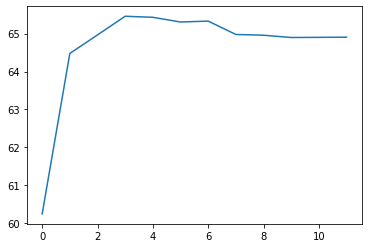

In [15]:
plt.plot(history['val_acc'])
plt.show()